# Buzzard redMaGiC Randoms Analysis

### Required Data:
http://www.slac.stanford.edu/~jderose/buzzard-flock/flock/Chinchilla-1/redmagic/redmagic_Y1a/buzzard_1.3_a_run_redmapper_v6.4.16_redmagic_highlum_1.0_vlim_area.fit

http://www.slac.stanford.edu/~jderose/buzzard-flock/flock/Chinchilla-1/redmagic/redmagic_Y1a/buzzard_1.3_a_run_redmapper_v6.4.16_redmagic_highlum_1.0-04_randoms.fit

We begin by getting the provided maximum area and the associated redshift range. Beyond that range, the area begins to drop off. Hence, we ignore those randoms to avoid any issues that will cause.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the area data.
hdu = fits.open('buzzard_1.3_a_run_redmapper_v6.4.16_redmagic_highlum_1.0_vlim_area.fit')
tbdata = hdu[1].data
z = tbdata['Z']
area = tbdata['area']

# Find the z bounds for which the area remains maximized.
max_area = np.max(area)
min_z = np.min(z[area == max_area])
max_z = np.max(z[area == max_area])

print('Maximum area: %f sq. deg.' % max_area)
print('Minimum z for which the area remains maximized: ', min_z)
print('Maximum z for which the area remains maximized: ', max_z)

Maximum area: 908.066528 sq. deg.
Minimum z for which the area remains maximized:  0.1
Maximum z for which the area remains maximized:  0.679


We now create a histogram of the ra and dec values for all randoms in the previously mentioned redshift range. The binned values are adjusted to ensure that all bins are of equal area.

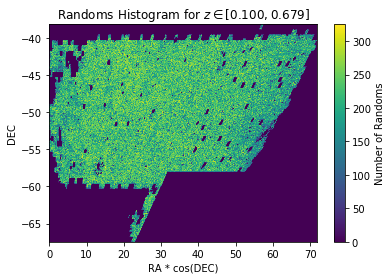

Area of each bin: 0.008418 sq. deg.
Number of bins with at least one random: 139318
Area of occupied bins: 1172 sq. deg.


In [2]:
# Load the randoms.
hdu = fits.open('buzzard_1.3_a_run_redmapper_v6.4.16_redmagic_highlum_1.0-04_randoms.fit')
tbdata = hdu[1].data
ra = tbdata['RA']
dec = tbdata['DEC']
z = tbdata['Z']

# Trim the data by redshift and account for curvature while binning.
ind = np.logical_and(z >= min_z, z <= max_z)
x = ra[ind] * np.cos(np.deg2rad(dec[ind]))
y = dec[ind]
num_randoms = np.sum(ind)

# Create the histogram of all randoms in adjusted ra and dec.
counts, xedges, yedges, im = plt.hist2d(x,y, bins=500)
cbar = plt.colorbar()
cbar.set_label('Number of Randoms')
plt.title('Randoms Histogram for $z \in [%0.3f,%0.3f]$' % (min_z,max_z))
plt.xlabel('RA * cos(DEC)')
plt.ylabel('DEC')
plt.show()

# Calculate the total area of all bins with one or more randoms in it.
dx = xedges[1]-xedges[0] # All bins have the same width in x
dy = yedges[1]-yedges[0] # All bins have the same width in y.
bin_area = dx*dy
num_occupied_bins = np.sum(counts > 0) # Get the number of bins with at least one random.
occupied_area = num_occupied_bins * bin_area

print('Area of each bin: %f sq. deg.' % bin_area)
print('Number of bins with at least one random: %d' % num_occupied_bins)
print('Area of occupied bins: %d sq. deg.' % occupied_area)

There appears to be a discrepancy between the provided area and the area calculated by the histogram.

Next we compare the surface density from the provided area and number counts with the density from the calculated area and most likely bin density.

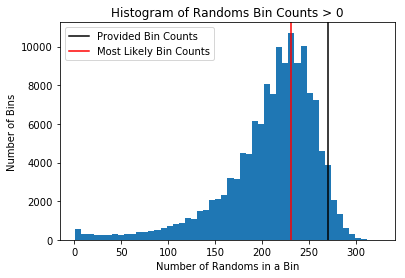

Expected number of randoms for the calculated area given the provided density:  37658820.1633
Expected number of randoms for the calculated area given the calculated density:  32188030.72
Ratio of calculated to provided expected randoms counts:  0.854727540068


In [3]:
# Calculate the trivial density from the provided area and number counts.
provided_density = num_randoms / max_area

# Create a histogram of the number counts for the occupied bins from the previous histogram.
n, bins, patches = plt.hist(counts[counts>0], bins=50)

# Determine the provided bin counts and most likely counts from the histogram.
provided_bin_count = provided_density * bin_area
calculated_bin_count = (bins[np.argmax(n)] + bins[np.argmax(n)+1])/2 # Use the midpoint of the most likely bin.

# Add the previously calculated densities to the plot.
avg_bar = plt.axvline(provided_bin_count, color='k', label='Provided Bin Counts')
max_bar = plt.axvline(calculated_bin_count, color='r', label = 'Most Likely Bin Counts')
plt.legend(handles=[avg_bar,max_bar], loc=2)
plt.title('Histogram of Randoms Bin Counts > 0')
plt.xlabel('Number of Randoms in a Bin')
plt.ylabel('Number of Bins')
plt.show()

# Determine the expected number counts from the calculated and provided densities for the calculated area.
provided_N = provided_bin_count * num_occupied_bins
expected_N = calculated_bin_count * num_occupied_bins

print('Expected number of randoms for the calculated area given the provided density: ', provided_N)
print('Expected number of randoms for the calculated area given the calculated density: ', expected_N)
print('Ratio of calculated to provided expected randoms counts: ', expected_N / provided_N)

As shown, the discrepancy in the calculated and provided areas naturally propagates into the surface densities. It can also be shown to affect the densities in 3D comoving Cartesian space.